In [ ]:
## 1. Transform data to record format
## First dataset from http://www.robots.ox.ac.uk/~vgg/data/scenetext/
## This method failed, because 

In [57]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import scipy.io as sio
import gzip
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
import tensorflow as tf
import skimage.io as skio
#tf.InteractiveSession()
from PIL import Image
import re
import os
slim = tf.contrib.slim
tf.__version__
#from image_processing2 import *
from processing import txt_preprocessing
import tf_extended as tfe
from processing import tf_image
from nets import txtbox_300
import tf_utils
from nets import custom_layers
import load_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
syntext = sio.loadmat('../data/sythtext/gt.mat')
syntext.keys()

KeyboardInterrupt: 

In [ ]:
wordBB = syntext['wordBB']
imnames = syntext['imnames']
txt = syntext['txt']
print imnames[0,10][0]
index = 10
img = cv2.imread(imnames[0,index][0])
bbox = wordBB[0,index]
text = txt[0,index]

In [ ]:
print bbox[:,:,0]
np.min(bbox[:,:,0],1)

In [1]:
def int64_feature(value):
    """Wrapper for inserting int64 features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def float_feature(value):
    """Wrapper for inserting float features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

In [2]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

In [3]:
_R_MEAN = 123.
_G_MEAN = 117.
_B_MEAN = 104.

# Some training pre-processing parameters.
BBOX_CROP_OVERLAP = 0.4        # Minimum overlap to keep a bbox after cropping.
CROP_RATIO_RANGE = (0.8, 1.2)  # Distortion ratio during cropping.
EVAL_SIZE = (300, 300)
def tf_image_whitened(image, means=[_R_MEAN, _G_MEAN, _B_MEAN]):
    """Subtracts the given means from each image channel.

    Returns:
        the centered image.
    """
    if image.get_shape().ndims != 3:
        raise ValueError('Input must be of size [height, width, C>0]')
    num_channels = image.get_shape().as_list()[-1]
    if len(means) != num_channels:
        raise ValueError('len(means) must match the number of channels')

    mean = tf.constant(means, dtype=image.dtype)
    image = image - mean
    return image


def tf_image_unwhitened(image, means=[_R_MEAN, _G_MEAN, _B_MEAN], to_int=True):
    """Re-convert to original image distribution, and convert to int if
    necessary.

    Returns:
      Centered image.
    """
    mean = tf.constant(means, dtype=image.dtype)
    image = image + mean
    if to_int:
        image = tf.cast(image, tf.int32)
    return image


def np_image_unwhitened(image, means=[_R_MEAN, _G_MEAN, _B_MEAN], to_int=True):
    """Re-convert to original image distribution, and convert to int if
    necessary. Numpy version.

    Returns:
      Centered image.
    """
    img = np.copy(image)
    img += np.array(means, dtype=img.dtype)
    if to_int:
        img = img.astype(np.uint8)
    return img

In [4]:
def distort_color(image, scope=None):
    """Distort the color of the image.

    Each color distortion is non-commutative and thus ordering of the color ops
    matters. Ideally we would randomly permute the ordering of the color ops.
    Rather then adding that level of complication, we select a distinct ordering
    of color ops for each preprocessing thread.

    Args:
    image: Tensor containing single image.
    thread_id: preprocessing thread ID.
    scope: Optional scope for op_scope.
    Returns:
    color-distorted image
    """
    with tf.name_scope( scope, 'distort_color',[image]):
        color_ordering = np.random.randint(2)

        if color_ordering == 0:
          image = tf.image.random_brightness(image, max_delta=32. / 255.)
          image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
          image = tf.image.random_hue(image, max_delta=0.2)
          image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        elif color_ordering == 1:
          image = tf.image.random_brightness(image, max_delta=32. / 255.)
          image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
          image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
          image = tf.image.random_hue(image, max_delta=0.2)

        # The random_* ops do not necessarily clamp.
        image = tf.clip_by_value(image, 0.0, 1.0)
        return image

In [74]:
with tf.Graph().as_default(): 
    # build a net
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern='50.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])
    
    image_train, glabels, gbboxes,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],is_training=True)
    image_test, labels, bboxes, bbox_img = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],is_training=False)
    batch_image = slim.batch_norm(image_train)
    #scala_image = tf.cast(image_train, tf.uint8)
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(1):
                image_, batch_image_,image_test_= sess.run([image_train,batch_image,image_test])

  
                
                

text_shape (300, 300)
file_path: ../data/sythtext/50.tfrecord


In [75]:
print image_test_.min(),image_test_.max()
print image_.min(),image_.max()

-119.0 151.0
-123.0 138.173


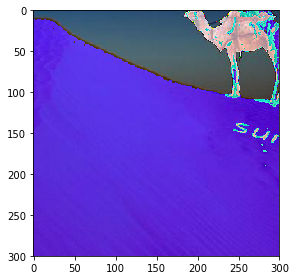

In [66]:
image_ = image_.astype(np.uint8)
#skio.imshow(np.uint8(image_bbox_p[0,:,:,:])*255)
skio.imshow(image_)




In [13]:
for i in range(6):
    pmask = gscores_[i] > 0.5
    print np.sum(pmask)
bbox_

0
0
19
0
0
0


array([[-0.16333333, -0.44173735,  0.49771667,  0.33278614],
       [-0.04792844,  0.44644988,  0.2283096 ,  1.05977964]], dtype=float32)

In [14]:
for i in range(6):
    print np.where(gscores_[i] >0.1)
gscores_[0].shape

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]), array([1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 1, 1, 2, 2, 2]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 1, 2, 1, 2, 3]))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


(38, 38, 2, 6)

In [10]:
loss

140.05319

In [13]:
pos_loss = 0
neg_loss = 0
for i in range(6):
    p_mask = np.int32(np.greater(b_gscores_[i] , 0.5))
    print np.sum(p_mask)
    n_mask = np.int32(np.less(b_gscores_[i] , 0.5))
    pos_loss += np.mean(pow((p_mask * (logits_[i][:,:,:,:,:,1] - p_mask)),2))
    neg_loss += np.mean(pow((n_mask * (logits_[i][:,:,:,:,:,0] - n_mask)),2))
print pos_loss,neg_loss

75
27
0
0
0
0
0.00275449878623 6.05501136631


In [9]:
with tf.Graph().as_default(): 
    # initalize the net
    net = txtbox_300.TextboxNet()
    out_shape = net.params.img_shape
    anchors = net.anchors(out_shape)

    # Create global_step.
    global_step = tf.Variable(0, name="global_step", trainable=False)
    
    # create batch dataset
    with tf.device('/cpu:0'):

        b_image, b_glocalisations, b_gscores = \
        load_batch.get_batch('../data/sythtext/',
                             1,
                             2,
                             out_shape,
                             net,
                             anchors,
                             1,
                             is_training = True)

    with tf.device('/cpu:0'):

        arg_scope = net.arg_scope(weight_decay=0.0005)

        with slim.arg_scope(arg_scope):
            localisations, logits, end_points = \
                    net.net(b_image, is_training=True)

        # Add loss function.
        total_loss = net.losses(logits, localisations,
                           b_glocalisations, b_gscores,
                           match_threshold=0.5,
                           negative_ratio=3,
                           alpha=10,
                           label_smoothing=0.0)

    # Gather summaries.
    summaries = set(tf.get_collection(tf.GraphKeys.SUMMARIES))

    for end_point in end_points:
        x = end_points[end_point]
        summaries.add(tf.summary.histogram('activations/' + end_point, x))
        summaries.add(tf.summary.scalar('sparsity/' + end_point,
                                        tf.nn.zero_fraction(x)))

    for loss in tf.get_collection(tf.GraphKeys.LOSSES):
        summaries.add(tf.summary.scalar(loss.op.name, loss))

    for loss in tf.get_collection('EXTRA_LOSSES'):
        summaries.add(tf.summary.scalar(loss.op.name, loss))

    for variable in slim.get_model_variables():
        summaries.add(tf.summary.histogram(variable.op.name, variable))

    with tf.device('/cpu:0'):
        #learning_rate = tf_utils.configure_learning_rate(FLAGS,
          #                                               FLAGS.num_samples,
        #                                              global_step)
        # Configure the optimization procedure 
        #optimizer = tf_utils.configure_optimizer(FLAGS, learning_rate)
        optimizer = tf.train.AdamOptimizer(1e-3)
        #summaries.add(tf.summary.scalar('learning_rate', learning_rate))

        ## Training 

        grads_and_vars = optimizer.compute_gradients(total_loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)
        

    # =================================================================== #
    # Kicks off the training.
    # =================================================================== #
    #gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=FLAGS.gpu_memory_fraction)
    config = tf.ConfigProto(log_device_placement=False,
                            allow_soft_placement = True)
    saver = tf.train.Saver(tf.global_variables(),
                           max_to_keep=5,
                           keep_checkpoint_every_n_hours=1.0,
                           write_version=2,
                           pad_step_number=False)

    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(2):
                loss = sess.run([total_loss])
                if i % 1 ==0:
                    print loss
                #current_step = tf.train.global_step(sess, global_step)
                '''
                if current_step % FLAGS.evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, writer=dev_summary_writer)
                    print("")
                if current_step % FLAGS.checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))
                '''

file_path: ../data/sythtext/*.tfrecord
[197.63361]
[197.36108]


In [10]:
for i in range(5):
    print i
    i = 0

0
1
2
3
4
